In [2]:
# !unzip data.zip 

In [3]:
import os
import glob 

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image
import torch
from torch import nn
from tqdm.auto import tqdm
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

Создадим тренировочный и валидационный датасеты и даталоадеры

In [4]:
PATH_TRAIN = './data/train'
PATH_VALID = './data/valid'

In [5]:
transform_train = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomAutocontrast(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_valid = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [6]:
train = ImageFolder(PATH_TRAIN, transform=transform_train)
valid = ImageFolder(PATH_VALID, transform=transform_valid)

train_dataloader = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=256, shuffle=False)

Посмотрим на наши данные 

In [7]:
train.classes

['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']

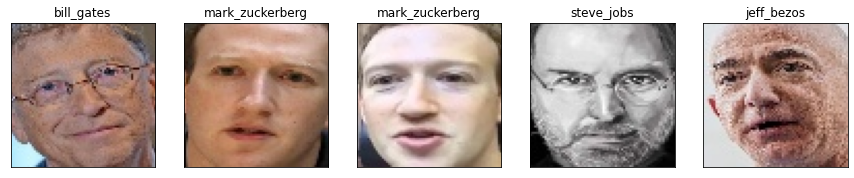

In [8]:
plt.figure(figsize=(15, 7))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    path_img = np.random.choice(glob.glob(os.path.join(PATH_TRAIN, '*/*.jpg')))
    img = plt.imread(path_img)
    plt.title(path_img.split('/')[-2])
    plt.imshow(img)


Загрузим предобученную модель

In [9]:
from torchvision.models import resnet50, resnet34

# model = resnet34(pretrained=True)
model = resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Поменяем последний слой сети

In [10]:
for param in model.parameters():
    param.requires_grad = False

In [11]:
# resnet34
# model.fc =  nn.Linear(in_features=512, out_features=len(train.classes), bias=True)

# resnet50
model.fc =  nn.Linear(in_features=2048, out_features=len(train.classes), bias=True)

Тренировка модели

In [12]:
def train_model(model, optimizer, train_dataloader, valid_dataloader, n_epochs=5):
    loss_train = []
    top1_train = []
    loss_valid = []
    top1_valid = []

    for epoch in range(n_epochs):
        losses = []
        equals = []
        torch.set_grad_enabled(True)
        model.train()

        for imgs, labels in tqdm(train_dataloader, desc=f"Training, epoch {epoch}", leave=False):
            # переносим на GPU при возможности
            imgs = imgs.to(device)
            labels = labels.to(device)

            # считаем сырые предсказания и функцию потерь
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)

            # делаем шаг обновления весов модели
            loss.backward()            
            optimizer.step()
            optimizer.zero_grad()

            # loss и equals
            losses.append(loss.item())
            equals.extend([eq.item() for eq in y_pred.argmax(1) == labels])
            
        loss_train.append(np.mean(losses))
        top1_train.append(np.mean(equals))

        # переключаем модель в режим валидации (быстрее, не храним ничего лишнего)
        losses = []
        equals = []
        torch.set_grad_enabled(False)
        model.eval()

        for imgs, labels in tqdm(valid_dataloader, desc=f"Validati, epoch {epoch}", leave=False):
            # переносим на GPU при возможности
            imgs = imgs.to(device)
            labels = labels.to(device)

            # считаем сырые предсказания и функцию потерь
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)

            # loss и equals
            losses.append(loss.item())
            equals.extend([eq.item() for eq in y_pred.argmax(1) == labels])

        loss_valid.append(np.mean(losses))
        top1_valid.append(np.mean(equals))

        print(f"Epoch: {epoch}")
        print(f"Train loss: {loss_train[-1]}, Train acc: {top1_train[-1]}, Valid loss: {loss_valid[-1]}, Valid acc {top1_valid[-1]}")

    return loss_train, top1_train, loss_valid, top1_valid

In [13]:
n_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [14]:
loss_train, top1_train, loss_valid, top1_valid = train_model(model, optimizer, train_dataloader, valid_dataloader, n_epochs)

Epoch: 0
Train loss: 1.2616577694813411, Train acc: 0.5336666666666666, Valid loss: 1.0635632574558258, Valid acc 0.6072210065645515


Epoch: 1
Train loss: 0.8180678735176722, Train acc: 0.7396666666666667, Valid loss: 0.6642706394195557, Valid acc 0.7833698030634574


Epoch: 2
Train loss: 0.6694010148445765, Train acc: 0.7813333333333333, Valid loss: 0.5719403252005577, Valid acc 0.8161925601750547


Epoch: 3
Train loss: 0.6044680426518122, Train acc: 0.8033333333333333, Valid loss: 0.5269325524568558, Valid acc 0.8358862144420132


Epoch: 4
Train loss: 0.5599302252133688, Train acc: 0.8163333333333334, Valid loss: 0.5020279213786125, Valid acc 0.8413566739606126


Epoch: 5
Train loss: 0.5161873201529185, Train acc: 0.8343333333333334, Valid loss: 0.5250447914004326, Valid acc 0.8347921225382933


Epoch: 6
Train loss: 0.5034567738572756, Train acc: 0.8416666666666667, Valid loss: 0.4737696573138237, Valid acc 0.8588621444201313


Epoch: 7
Train loss: 0.4690743883450826, Train acc: 0.8453333333333334, Valid loss: 0.4673662334680557, Valid acc 0.8544857768052516


Epoch: 8
Train loss: 0.46924178302288055, Train acc: 0.8483333333333334, Valid loss: 0.43465572968125343, Valid acc 0.8555798687089715


Epoch: 9
Train loss: 0.4492138971885045, Train acc: 0.8496666666666667, Valid loss: 0.4268181473016739, Valid acc 0.862144420131291


Epoch: 10
Train loss: 0.4398537526528041, Train acc: 0.8496666666666667, Valid loss: 0.4422142505645752, Valid acc 0.8654266958424508


Epoch: 11
Train loss: 0.43317855646212894, Train acc: 0.8606666666666667, Valid loss: 0.4299459308385849, Valid acc 0.862144420131291


Epoch: 12
Train loss: 0.4108298644423485, Train acc: 0.868, Valid loss: 0.4047989547252655, Valid acc 0.8665207877461707


Epoch: 13
Train loss: 0.40000970164934796, Train acc: 0.866, Valid loss: 0.38838379085063934, Valid acc 0.8676148796498906


Epoch: 14
Train loss: 0.38469495872656506, Train acc: 0.8776666666666667, Valid loss: 0.3974289670586586, Valid acc 0.8643326039387309


Epoch: 15
Train loss: 0.38816794753074646, Train acc: 0.8793333333333333, Valid loss: 0.38147397339344025, Valid acc 0.8708971553610503


Epoch: 16
Train loss: 0.3766698017716408, Train acc: 0.8793333333333333, Valid loss: 0.3914606124162674, Valid acc 0.8643326039387309


Epoch: 17
Train loss: 0.37849292655785877, Train acc: 0.874, Valid loss: 0.38070373609662056, Valid acc 0.8763676148796499


Epoch: 18
Train loss: 0.36195601026217145, Train acc: 0.8813333333333333, Valid loss: 0.37201252952218056, Valid acc 0.87527352297593


Epoch: 19
Train loss: 0.3519325057665507, Train acc: 0.89, Valid loss: 0.37658024206757545, Valid acc 0.8774617067833698


Epoch: 20
Train loss: 0.35709311813116074, Train acc: 0.8843333333333333, Valid loss: 0.36349988728761673, Valid acc 0.8774617067833698


Epoch: 21
Train loss: 0.34562413146098453, Train acc: 0.892, Valid loss: 0.3539215810596943, Valid acc 0.888402625820569


Epoch: 22
Train loss: 0.3416912580529849, Train acc: 0.892, Valid loss: 0.3486102633178234, Valid acc 0.8840262582056893


Epoch: 23
Train loss: 0.3356497064232826, Train acc: 0.892, Valid loss: 0.3581654131412506, Valid acc 0.8840262582056893


Epoch: 24
Train loss: 0.33363422999779385, Train acc: 0.8923333333333333, Valid loss: 0.3701763078570366, Valid acc 0.8807439824945296


Epoch: 25
Train loss: 0.32396329442660016, Train acc: 0.896, Valid loss: 0.3533610515296459, Valid acc 0.8829321663019694


Epoch: 26
Train loss: 0.3254307135939598, Train acc: 0.8943333333333333, Valid loss: 0.33923719078302383, Valid acc 0.8905908096280087


Epoch: 27
Train loss: 0.32050850987434387, Train acc: 0.8923333333333333, Valid loss: 0.34252382814884186, Valid acc 0.8851203501094091


Epoch: 28
Train loss: 0.31226440767447156, Train acc: 0.9053333333333333, Valid loss: 0.34668121114373207, Valid acc 0.8829321663019694


Epoch: 29
Train loss: 0.3139850025375684, Train acc: 0.8993333333333333, Valid loss: 0.33240431547164917, Valid acc 0.8862144420131292


Epoch: 30
Train loss: 0.29460686072707176, Train acc: 0.9106666666666666, Valid loss: 0.33899127691984177, Valid acc 0.8862144420131292


Epoch: 31
Train loss: 0.3067440253992875, Train acc: 0.9023333333333333, Valid loss: 0.3296826519072056, Valid acc 0.8916849015317286


Epoch: 32
Train loss: 0.2937204986810684, Train acc: 0.9116666666666666, Valid loss: 0.31765542924404144, Valid acc 0.899343544857768


Epoch: 33
Train loss: 0.3011323908964793, Train acc: 0.9073333333333333, Valid loss: 0.31964127719402313, Valid acc 0.8916849015317286


Epoch: 34
Train loss: 0.2897067380448182, Train acc: 0.9116666666666666, Valid loss: 0.3239254169166088, Valid acc 0.8905908096280087


Epoch: 35
Train loss: 0.28745704392592114, Train acc: 0.913, Valid loss: 0.3175639919936657, Valid acc 0.8982494529540481


Epoch: 36
Train loss: 0.2847359689573447, Train acc: 0.9103333333333333, Valid loss: 0.31288905441761017, Valid acc 0.8982494529540481


Epoch: 37
Train loss: 0.28583839039007825, Train acc: 0.9166666666666666, Valid loss: 0.3080717921257019, Valid acc 0.9004376367614879


Epoch: 38
Train loss: 0.28078223516543704, Train acc: 0.9133333333333333, Valid loss: 0.32799864932894707, Valid acc 0.8960612691466083


Epoch: 39
Train loss: 0.29075716187556583, Train acc: 0.9133333333333333, Valid loss: 0.3111986108124256, Valid acc 0.8916849015317286


Epoch: 40
Train loss: 0.2803965111573537, Train acc: 0.9153333333333333, Valid loss: 0.3261248357594013, Valid acc 0.888402625820569


Epoch: 41
Train loss: 0.2708800708254178, Train acc: 0.918, Valid loss: 0.31266509741544724, Valid acc 0.899343544857768


Epoch: 42
Train loss: 0.27396201714873314, Train acc: 0.9196666666666666, Valid loss: 0.30958541110157967, Valid acc 0.9026258205689278


Epoch: 43
Train loss: 0.26622547457615536, Train acc: 0.9183333333333333, Valid loss: 0.3106946423649788, Valid acc 0.8916849015317286


Epoch: 44
Train loss: 0.2618303174773852, Train acc: 0.924, Valid loss: 0.3162980228662491, Valid acc 0.8938730853391685


Epoch: 45
Train loss: 0.26544125005602837, Train acc: 0.9216666666666666, Valid loss: 0.30621369928121567, Valid acc 0.9059080962800875


Epoch: 46
Train loss: 0.250203521301349, Train acc: 0.9256666666666666, Valid loss: 0.29979167878627777, Valid acc 0.9080962800875274


Epoch: 47
Train loss: 0.25431721409161884, Train acc: 0.9223333333333333, Valid loss: 0.30811311304569244, Valid acc 0.8949671772428884


Epoch: 48
Train loss: 0.2684166580438614, Train acc: 0.9183333333333333, Valid loss: 0.30635734647512436, Valid acc 0.9004376367614879


Epoch: 49
Train loss: 0.25304044286410016, Train acc: 0.919, Valid loss: 0.2965787388384342, Valid acc 0.912472647702407


Посмотрим на графики логов лосса и метрики

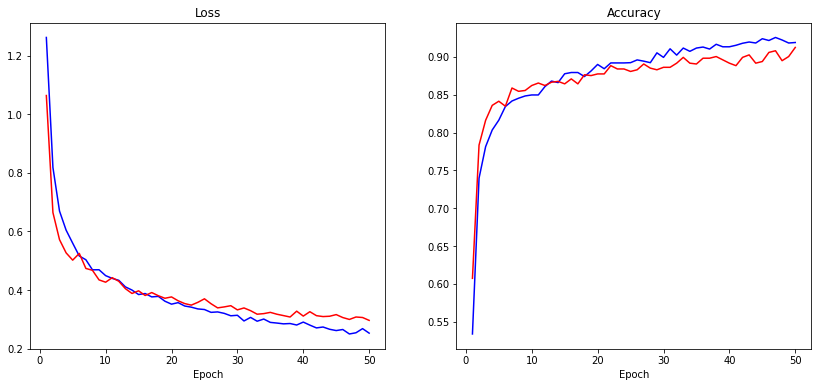

In [18]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("Epoch")
plt.title("Loss")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), top1_train, color="b")
plt.plot(range(1, len(loss_train) + 1), top1_valid, color="r")
plt.xlabel("Epoch")
plt.title("Accuracy")

plt.show()

***Точность нашей модели 91%***

Сделаем инференс на случайных картинках и отрисуем результаты

In [19]:
classes = {v: k for k, v in valid.class_to_idx.items()}

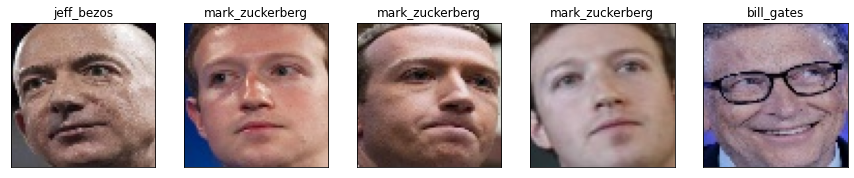

In [22]:
plt.figure(figsize=(15, 7))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    path_img = np.random.choice(glob.glob(os.path.join(PATH_VALID, '*/*.jpg')))
    img = plt.imread(path_img)
    tensor = transform_valid(Image.open(path_img))[None]
    with torch.no_grad():
        pred = model(tensor.to(device)).to('cpu').argmax().item()
    img = plt.imread(path_img)
    plt.title(classes[pred])
    plt.imshow(img)